In [1]:
import torch
import torchvision
import gc
import pandas as pd
import numpy as np
import time

# Проверяем какое устройство подключено
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("", device, "device")

# Очищаем кэш
gc.collect()
torch.cuda.empty_cache()

 cuda device


In [2]:
# Итерационно получаем значения скорости выполнения перемножений таблиц с изменением их размерностей
# на 1 еденицу с каждым шагом. Для GPU проводим 3 теста на каждом шаге 
# для уточнения данных и сглаживания  погрешности

n = 3
m = 0
my_list = []
while m < 31:
    my_list.append([])
    for i in range(1):
        matrix_size = (90+m)*(90+m)
        my_list[m].append(matrix_size/(90+m))
        x = torch.randn(matrix_size, matrix_size)
        y = torch.randn(matrix_size, matrix_size)

        start = time.time()
        result_tr = torch.matmul(x, y)
        my_list[m].append(time.time() - start)
        torch.cuda.synchronize()
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        my_list.append([])
        for i in range(3):
            start = time.time()
            result_gpu = torch.matmul(x_gpu, y_gpu)
            torch.cuda.synchronize()
            my_list[m].append(time.time() - start)
    m = m + 1
    print(m)

gc.collect()
torch.cuda.empty_cache()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


<AxesSubplot: xlabel='LenMatrix'>

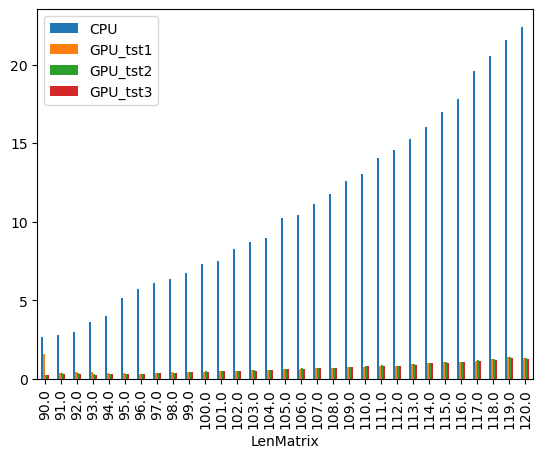

In [10]:
# Полученные значения из листа преобразовуем в dataframe
df = pd.DataFrame(my_list)
df.columns =['LenMatrix', 'CPU','GPU_tst1', 'GPU_tst2', 'GPU_tst3']
df = df[df.LenMatrix > 0]
# Строим график изменения скорости 
df.groupby('LenMatrix').sum().plot(kind='bar')

In [39]:
#Найдем ускорение CPU
accelCPU = (df.CPU[len(df)-1] - df.CPU[0])/df.CPU[0]
#Найдем среднее ускорение для первого и последнего теста GPU
#тк в первом значении есть выброс берем начиная со 2го значения
mean_accelGPU1 = (df.GPU_tst1[1]+df.GPU_tst2[1]+df.GPU_tst3[1])/3
mean_accelGPUmax = (df.GPU_tst1[len(df)-1]+df.GPU_tst2[len(df)-1]+df.GPU_tst3[len(df)-1])/3
accelGPU = (mean_accelGPUmax - mean_accelGPU1)/mean_accelGPU1

print('При увеличении размера каждой плоскости матрицы на 30 ед.',
      'увеличивается длительность выполнения вычисления в')
print('Для CPU:',
      f"{accelCPU:.{1}f}",'раза')
print('Для GPU:',
      f"{accelGPU:.{1}f}",'раза')
print('При размере матрицы 120*120 вычисление на GPU происходит в',f"{(df.CPU[len(df)-1])/mean_accelGPUmax:.{0}f}",'раз быстрее')

При увеличении размера каждой плоскости матрицы на 30 ед. увеличивается длительность выполнения вычисления в
Для CPU: 7.3 раза
Для GPU: 2.5 раза
При размере матрицы 120*120 вычисление на GPU происходит в 17 раз быстрее
